In [1]:
!pip install "numpy>=1.16.5,<1.23.0"

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.8/16.8 MB 57.3 MB/s eta 0:00:0000:0100:01
  Attempting uninstall: numpy
    Found existing installation: numpy 1.24.3
    Uninstalling numpy-1.24.3:
      Successfully uninstalled numpy-1.24.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cudf 23.8.0 requires cupy-cuda11x>=12.0.0, which is not installed.
cuml 23.8.0 requires cupy-cuda11x>=12.0.0, which is not installed.
dask-cudf 23.8.0 requires cupy-cuda11x>=12.0.0, which is not installed.
apache-beam 2.46.0 requires dill<0.3.2,>=0.3.1.1, but you have dill 0.3.7 which is incompatible.
apache-beam 2.46.0 requires pyarrow<10.0.0,>=3.0.0, but you have pyarrow 11.0.0 which is incompatible.
chex 0.1.85 requires numpy>=1.24.1, but you have numpy 1.22.4 which is incompatible.
cudf 23.8.0 requires pandas<1.6.0dev0,>=1.3, but you have pandas 2.0.3 which is incompatible

In [2]:
import numpy as np

In [3]:
import importlib
importlib.reload(np)

/opt/conda/lib/python3.10/importlib/__init__.py:169: UserWarning: The NumPy module was reloaded (imported a second time). This can in some cases result in small but subtle issues and is discouraged.
  _bootstrap._exec(spec, module)


<module 'numpy' from '/opt/conda/lib/python3.10/site-packages/numpy/__init__.py'>

In [4]:
import os
import json
import cv2
from tqdm import tqdm
import shutil
import random
import gc

from PIL import Image
from collections import defaultdict

import pandas as pd
import matplotlib.pyplot as plt

import torch
import torchvision
from torchvision import models
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import albumentations as A
from albumentations.pytorch import ToTensorV2

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [5]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [6]:
torch.cuda.device_count()

1

# Load data

In [7]:
train_labels = pd.read_csv('/kaggle/input/module3-files/module3_files/train.csv')

In [8]:
train_labels.head(5)

,ImageId,EncodedPixels,Height,Width,ClassId,AttributesIds
0,00000663ed1ff0c4e0132b9b9ac53f6e,6068157 7 6073371 20 6078584 34 6083797 48 608...,5214,3676,6,"115,136,143,154,230,295,316,317"
1,00000663ed1ff0c4e0132b9b9ac53f6e,6323163 11 6328356 32 6333549 53 6338742 75 63...,5214,3676,0,"115,136,142,146,225,295,316,317"
2,00000663ed1ff0c4e0132b9b9ac53f6e,8521389 10 8526585 30 8531789 42 8537002 46 85...,5214,3676,28,163
3,00000663ed1ff0c4e0132b9b9ac53f6e,12903854 2 12909064 7 12914275 10 12919485 15 ...,5214,3676,31,"160,204"
4,00000663ed1ff0c4e0132b9b9ac53f6e,10837337 5 10842542 14 10847746 24 10852951 33...,5214,3676,32,219


In [9]:
with open('/kaggle/input/module3-files/module3_files/label_descriptions.json', 'r') as file:
    label_desc_json = json.load(file)

In [10]:
categories_data = pd.DataFrame(label_desc_json['categories'])
attributes_data = pd.DataFrame(label_desc_json['attributes'])

In [11]:
category_map, attribute_map = {}, {}

for _, row in categories_data.iterrows():
    category_map[row['id']] = row['name']

for _, row in attributes_data.iterrows():
    attribute_map[row['id']] = row['name']

In [12]:
train_labels['ClassIdCategory'] = train_labels['ClassId'].map(category_map)
train_labels['ClassIdCategory'] = train_labels['ClassIdCategory'].astype('category')

In [13]:
category_distribution = (train_labels['ClassIdCategory'].value_counts()).to_frame()
category_distribution.reset_index(inplace=True)
category_distribution.columns=['category','count']

# Split labeled data into test and train

In [14]:
# shutil.rmtree('/kaggle/working/resized_validation')
# shutil.rmtree('/kaggle/working/resized_train')

In [15]:
old_train_directory = '/kaggle/input/module3-files/module3_files/resized_train'
validation_directory = '/kaggle/working/resized_validation'
train_directory = '/kaggle/working/resized_train'

os.makedirs(train_directory, exist_ok=False)
os.makedirs(validation_directory, exist_ok=False)

num_files_to_move = int(0.2 * len(os.listdir(old_train_directory)))
files_to_move_for_validation = random.sample(os.listdir(old_train_directory), num_files_to_move)

for source_path in tqdm(os.listdir(old_train_directory)):
    source_file = os.path.join(old_train_directory, source_path)
    
    if source_path in files_to_move_for_validation:
        destination_file = os.path.join(validation_directory, source_path)
        shutil.copy(source_file, destination_file)
    else:
        destination_file = os.path.join(train_directory, source_path)
        shutil.copy(source_file, destination_file)

100%|██████████| 45623/45623 [07:53<00:00, 96.40it/s] 


In [16]:
gc.collect()

0

In [17]:
train_directory = '/kaggle/working/resized_train'

for file_name in os.listdir(train_directory):
  file_path = os.path.join(train_directory, file_name)
  if cv2.imread(file_path) is None:
    os.remove(file_path)
    print(f"Deleted file from resized_train: {file_name}")

print('---')

validation_directory = '/kaggle/working/resized_validation'

for file_name in os.listdir(validation_directory):
    file_path = os.path.join(validation_directory, file_name)
    if cv2.imread(file_path) is None:
        os.remove(file_path)
        print(f"Deleted file from resized_validation: {file_name}")

---


# Prepare dataset

In [18]:
categories_ids = categories_data['id'].values.tolist()

In [19]:
# classes_dict = {}

# for image_name in tqdm(os.listdir(train_directory)):
#   img_labels = train_labels[train_labels['ImageId'] == image_name.split('.')[0]]['ClassId'].values.tolist()
#   classes_dict[image_name] = img_labels

# for image_name in tqdm(os.listdir(validation_directory)):
#   img_labels = train_labels[train_labels['ImageId'] == image_name.split('.')[0]]['ClassId'].values.tolist()
#   classes_dict[image_name] = img_labels

In [20]:
classes_dict = {}
for image_id, class_id in zip(train_labels['ImageId'], train_labels['ClassId']):
    if image_id not in classes_dict:
        classes_dict[image_id] = []
    classes_dict[image_id].append(class_id)

In [21]:
def get_image(img_name, subset):
  return cv2.imread(f'{subset}/{img_name}')

In [22]:
class TripletFashionDataset(Dataset):
    def __init__(self, image_dir, transform=None):
        self.image_dir = image_dir
        self.image_fns = os.listdir(image_dir)
        self.transform = transform
        self.images = []
        self.img_labels = []
        self.labels = []

        for img_name in self.image_fns:
            image = np.array(cv2.cvtColor(get_image(img_name, self.image_dir.split("/")[-1]), cv2.COLOR_BGR2RGB))

            if self.transform is not None:
                image = self.transform(image=image)['image']

            img_label, label = self.encode_label(img_name.split('.')[0], self.image_dir.split('/')[-1])
            
            self.img_labels.append(img_label)
            self.images.append(image)
            self.labels.append(label)

        self.triplets = self.form_triplets()
        
    def encode_label(self, img_name, subset):
      img_labels = classes_dict[img_name]

      encodings = torch.zeros(46)
      for idx_label in img_labels:
        encodings[int(idx_label)] = 1

      return img_labels, encodings

    def form_triplets(self):
        triplets = []

        for anchor_index, anchor_label in tqdm(enumerate(self.labels)):
            
            anchor_img_label = self.img_labels[anchor_index]
            
            negatives = []
            positives = []
            
            for idx, curr in enumerate(self.img_labels):
                if idx == anchor_index:
                    continue
                    
                if len(list(set(curr) & set(anchor_img_label))) == 0:
                       negatives.append(idx)
                if len(list(set(curr) & set(anchor_img_label))) >= 1:
                       positives.append(idx)
                       
                if (len(negatives) >= 1 and len(positives) >= 1):
                    break            
            
            positive_index = random.choice(positives)
            negative_index = random.choice(negatives)
            
            triplets.append((anchor_index, positive_index, negative_index))

        return triplets

    def __len__(self):
        return len(self.triplets)

    def __getitem__(self, idx):
        anchor_idx, positive_idx, negative_idx = self.triplets[idx]

        anchor = self.images[anchor_idx]
        positive = self.images[positive_idx]
        negative = self.images[negative_idx]

        return anchor, positive, negative

In [23]:
train_transform = A.Compose(
    [
        A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
        ToTensorV2()
    ]
)

valid_transform = A.Compose(
    [
        A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
        ToTensorV2()
    ]
)

In [24]:
train_dataset = TripletFashionDataset(image_dir=train_directory, transform=train_transform)
validation_dataset = TripletFashionDataset(image_dir=validation_directory, transform=valid_transform)

36499it [00:01, 25034.45it/s]
9124it [00:00, 12201.14it/s]


# Model training with metric learning

In [47]:
def calculate_accuracy(output_anchor, output_positive, output_negative, margin=0.0):
    
    positive_distance = torch.nn.functional.pairwise_distance(output_anchor, output_positive)
    negative_distance = torch.nn.functional.pairwise_distance(output_anchor, output_negative)
    correct_triplets = (positive_distance < negative_distance + margin).sum().item()

    total_triplets = output_anchor.size(0)
    accuracy = correct_triplets / total_triplets

    return accuracy

In [48]:
def calculate_loss(output_anchor, output_positive, output_negative):
    triplet_loss = nn.TripletMarginWithDistanceLoss(margin=0.0, distance_function=torch.nn.functional.pairwise_distance)
    loss = triplet_loss(output_anchor, output_positive, output_negative)
    
    return loss

In [49]:
class MetricMonitor:
    def __init__(self, float_precision=4):
        self.float_precision = float_precision
        self.reset()

    def reset(self):
        self.metrics = defaultdict(lambda: {"value": 0, "count": 0, "avg": 0})

    def update(self, metric_name, val):
        metric = self.metrics[metric_name]

        metric["value"] += val
        metric["count"] += 1
        metric["avg"] = metric["value"] / metric["count"]

    def __str__(self):
        return " | ".join(
            [
                "{metric_name}: {avg:.{float_precision}f}".format(
                    metric_name=metric_name, avg=metric["avg"], float_precision=self.float_precision
                )
                for (metric_name, metric) in self.metrics.items()
            ]
        )

In [50]:
def train(train_loader, model, optimizer, epoch, params):
    metric_monitor = MetricMonitor()
    model.to(params['device'])
    model.train()
    stream = tqdm(train_loader)

    all_losses = []
    all_steps = []

    for i, (anchor, positive, negative) in enumerate(stream, start=1):
        anchor = anchor.to(params["device"], dtype=torch.float32)
        positive = positive.to(params["device"], dtype=torch.float32)
        negative = negative.to(params["device"], dtype=torch.float32)

        output_anchor = model(anchor)
        output_positive = model(positive)
        output_negative = model(negative)
        
        loss = calculate_loss(output_anchor, output_positive, output_negative)
        accuracy = calculate_accuracy(output_anchor, output_positive, output_negative)

        metric_monitor.update("Loss", loss.item())
        metric_monitor.update("Accuracy", accuracy)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        stream.set_description(
            "Epoch: {epoch}. Train.      {metric_monitor}".format(epoch=epoch, metric_monitor=metric_monitor)
        )

        all_losses.append(loss.item())
        all_steps.append(epoch * len(train_loader) + i)

    return (metric_monitor.metrics["Loss"]["avg"], metric_monitor.metrics["Accuracy"]["avg"], all_losses, all_steps)

In [51]:
def validate(val_loader, model, epoch, params):
    metric_monitor = MetricMonitor()
    model.to(params['device'])
    model.eval()
    stream = tqdm(val_loader)

    all_losses = []
    all_steps = []

    with torch.no_grad():
        for i, (anchor, positive, negative) in enumerate(stream, start=1):
            anchor = anchor.to(params["device"], dtype=torch.float32)
            positive = positive.to(params["device"], dtype=torch.float32)
            negative = negative.to(params["device"], dtype=torch.float32)

            output_anchor = model(anchor)
            output_positive = model(positive)
            output_negative = model(negative)
        
            loss = calculate_loss(output_anchor, output_positive, output_negative)
            accuracy = calculate_accuracy(output_anchor, output_positive, output_negative)

            metric_monitor.update("Loss", loss.item())
            metric_monitor.update("Accuracy", accuracy)
            stream.set_description(
                "Epoch: {epoch}. Validation.      {metric_monitor}".format(epoch=epoch, metric_monitor=metric_monitor)
            )

            all_losses.append(loss.item())
            all_steps.append(epoch * len(train_loader) + i)

    return (metric_monitor.metrics["Loss"]["avg"], metric_monitor.metrics["Accuracy"]["avg"], all_losses, all_steps)

# Metric learning model training

In [64]:
params_mn2 = {
    "device": device,
    "lr": 0.0005,
    "batch_size": 32,
    "num_workers": 4,
    "epochs": 7,
}

In [65]:
train_loader = DataLoader(
    train_dataset, batch_size=params_mn2["batch_size"], shuffle=True, pin_memory=True, num_workers=params_mn2["num_workers"],
)
validation_loader = DataLoader(
    validation_dataset, batch_size=params_mn2["batch_size"], shuffle=False, pin_memory=True, num_workers=params_mn2["num_workers"],
)

In [66]:
weights = models.MobileNet_V2_Weights.IMAGENET1K_V1
model_mn2 = models.mobilenet_v2(weights=weights)

In [67]:
model_mn2.classifier = nn.Sequential(
    model_mn2.classifier,
    nn.Linear(1000, len(categories_ids)),
    nn.Sigmoid()
)

In [68]:
optimizer_mn2 = torch.optim.Adam(model_mn2.parameters(), lr = params_mn2['lr'])

In [69]:
train_metrics_lst = []
validation_metrics_lst = []

for epoch in range(1, params_mn2["epochs"] + 1):
    train_metrics = train(train_loader, model_mn2, optimizer_mn2, epoch, params_mn2)
    validation_metrics = validate(validation_loader, model_mn2, epoch, params_mn2)

    train_metrics_lst.append(train_metrics)
    validation_metrics_lst.append(validation_metrics)

Epoch: 1. Train.      Loss: 0.0035 | Accuracy: 0.9202: 100%|██████████| 1141/1141 [02:07<00:00,  8.95it/s]
Epoch: 1. Validation.      Loss: 0.0002 | Accuracy: 0.5391: 100%|██████████| 286/286 [00:09<00:00, 29.75it/s]
Epoch: 2. Train.      Loss: 0.0000 | Accuracy: 0.9355: 100%|██████████| 1141/1141 [02:07<00:00,  8.93it/s]
Epoch: 2. Validation.      Loss: 0.0001 | Accuracy: 0.5390: 100%|██████████| 286/286 [00:09<00:00, 30.01it/s]
Epoch: 3. Train.      Loss: 0.0000 | Accuracy: 0.9478: 100%|██████████| 1141/1141 [02:07<00:00,  8.92it/s]
Epoch: 3. Validation.      Loss: 0.0001 | Accuracy: 0.5496: 100%|██████████| 286/286 [00:09<00:00, 30.59it/s]
Epoch: 4. Train.      Loss: 0.0000 | Accuracy: 0.9636: 100%|██████████| 1141/1141 [02:07<00:00,  8.95it/s]
Epoch: 4. Validation.      Loss: 0.0000 | Accuracy: 0.5276: 100%|██████████| 286/286 [00:09<00:00, 29.61it/s]
Epoch: 5. Train.      Loss: 0.0000 | Accuracy: 0.9655: 100%|██████████| 1141/1141 [02:07<00:00,  8.94it/s]
Epoch: 5. Validation.    

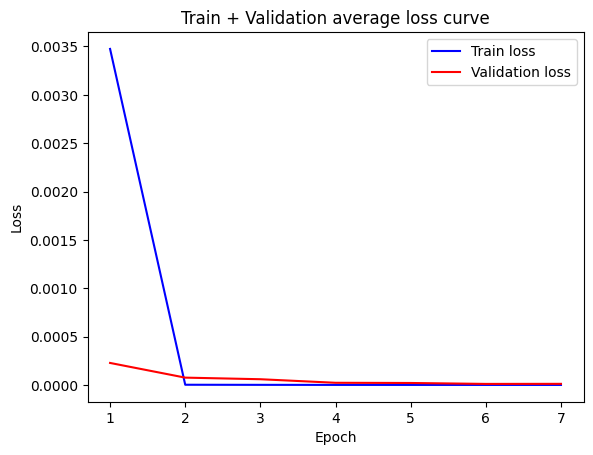

In [70]:
plt.plot(np.arange(1, params_mn2['epochs'] + 1, 1), [metric[0] for metric in train_metrics_lst], color='b', label='Train loss')
plt.plot(np.arange(1, params_mn2['epochs'] + 1, 1), [metric[0] for metric in validation_metrics_lst], color='r', label='Validation loss')

plt.title('Train + Validation average loss curve')

plt.xlabel('Epoch')
plt.ylabel('Loss')

plt.legend()

plt.show()

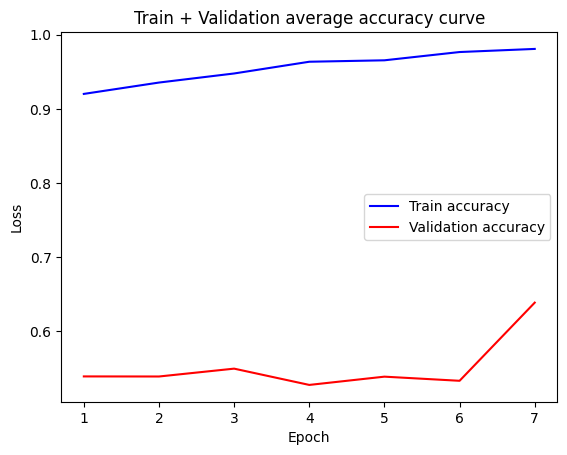

In [72]:
plt.plot(np.arange(1, params_mn2['epochs'] + 1, 1), [metric[1] for metric in train_metrics_lst], color='b', label='Train accuracy')
plt.plot(np.arange(1, params_mn2['epochs'] + 1, 1), [metric[1] for metric in validation_metrics_lst], color='r', label='Validation accuracy')

plt.title('Train + Validation average accuracy curve')

plt.xlabel('Epoch')
plt.ylabel('Loss')

plt.legend()

plt.show()

In [73]:
torch.save(model_mn2.state_dict(), '/kaggle/working/model_mn2_metric_learning.pth')